In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

data_frame = pd.read_csv('data.csv')
len(data_frame)
target_msrp = 'msrp'

In [2]:
data_frame.columns = data_frame.columns.str.lower().str.replace(' ', '_')

string_columns = list(data_frame.dtypes[data_frame.dtypes == 'object'].index)

for column in string_columns:
    data_frame[column] = data_frame[column].str.lower().str.replace(' ', '_')

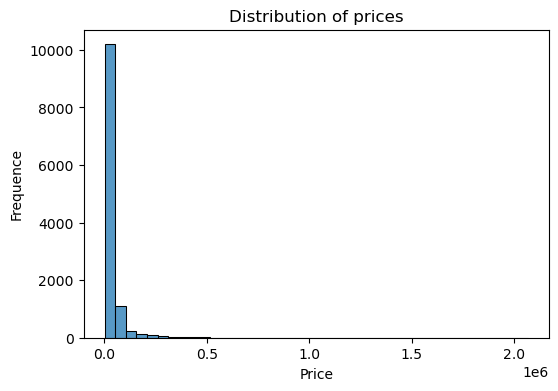

In [3]:
plt.figure(figsize=(6, 4))
sns.histplot(data_frame[target_msrp], bins=40)
plt.xlabel('Price')
plt.ylabel('Frequence')
plt.title('Distribution of prices')
plt.show()

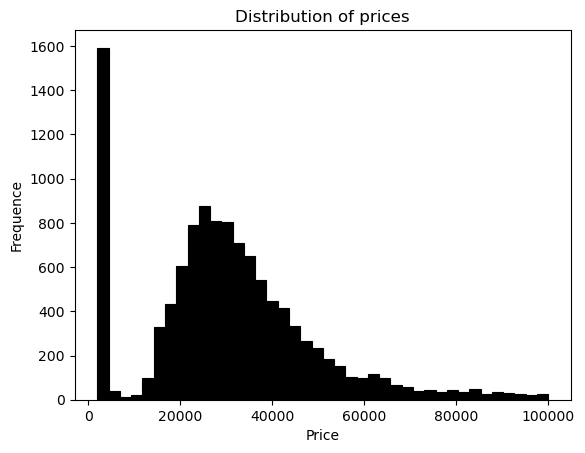

In [4]:
msrp_less_than_10000 = data_frame[target_msrp] < 100000

sns.histplot(data_frame.msrp[msrp_less_than_10000], bins=40, color='black', alpha=1)
plt.xlabel('Price')
plt.ylabel('Frequence')
plt.title('Distribution of prices')
plt.show()


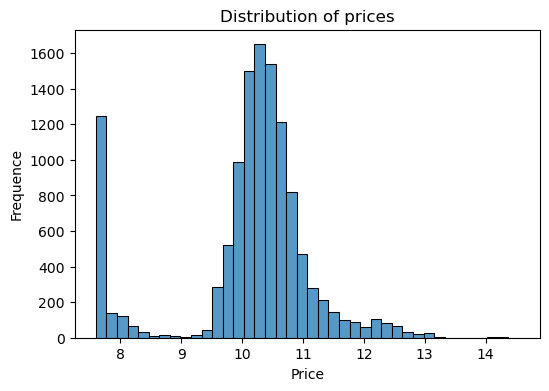

In [5]:
log_price = np.log1p(data_frame[target_msrp])
plt.figure(figsize=(6, 4))
sns.histplot(log_price, bins=40)
plt.xlabel('Price')
plt.ylabel('Frequence')
plt.title('Distribution of prices')
plt.show()

In [6]:
data_frame[target_msrp].isnull()

0        False
1        False
2        False
3        False
4        False
         ...  
11909    False
11910    False
11911    False
11912    False
11913    False
Name: msrp, Length: 11914, dtype: bool

### Validation Framework


In [7]:
number_of_data = len(data_frame)
number_of_validation = int(0.2 * number_of_data)
number_of_test = int(0.2 * number_of_data)
number_of_train = number_of_data - (number_of_validation + number_of_test)
index = np.arange(number_of_data)
np.random.seed(2)
np.random.shuffle(index)
df_shuffled = data_frame.iloc[index]

df_train = df_shuffled.iloc[:number_of_train].copy()
df_validation = df_shuffled.iloc[number_of_train:number_of_train + number_of_validation].copy()
df_test = df_shuffled.iloc[number_of_train + number_of_validation:].copy()


y_train = np.log1p(df_train[target_msrp].values)
y_validation = np.log1p(df_validation[target_msrp].values)
y_test = np.log1p(df_test[target_msrp].values)

del df_train[target_msrp]
del df_validation[target_msrp]
del df_test[target_msrp]

### Linear Regression

In [14]:
def train_linear_regression(X, y):
    rows_count_of_X = X.shape[0]
    ones = np.ones(rows_count_of_X)
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    return (w[0], w[1:])

### Baseline Solution

In [21]:
def prepare_X(df):
    base = ['engine_hp','engine_cylinders', 'highway_mpg', 'city_mpg', 'popularity']
    df_features = df[base]
    df_features = df_features.fillna(0)
    X = df_features.values
    return X

In [17]:
X_train = prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train)

In [18]:
y_prediction = w_0 + X_train.dot(w)

In [19]:
plt.figure(figsize=(6, 4))

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

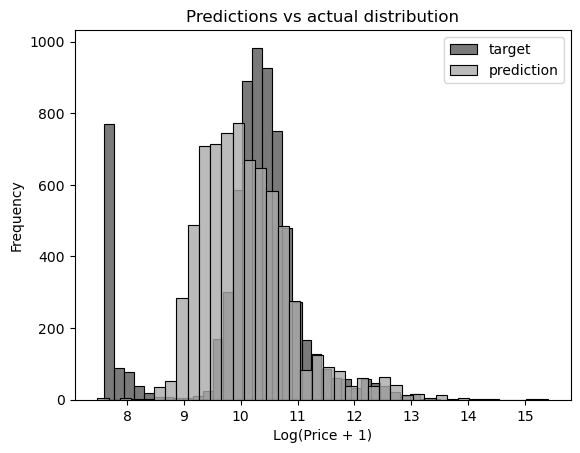

In [20]:
sns.histplot(y_train, label='target', color='#222222', alpha=0.6, bins=40)
sns.histplot(y_prediction, label='prediction', color='#aaaaaa', alpha=0.8, bins=40)
plt.legend()

plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title('Predictions vs actual distribution')

plt.show()